<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/InverseLinkPredcition/blob/main/Sparcification_ML_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
286/286 [==============================] - 2s 4ms/step - loss: 1.1274 - accuracy: 0.5460 - val_loss: 0.8066 - val_accuracy: 0.6538
Epoch 2/50
286/286 [==============================] - 1s 4ms/step - loss: 0.7499 - accuracy: 0.6841 - val_loss: 0.6235 - val_accuracy: 0.7299
Epoch 3/50
286/286 [==============================] - 1s 3ms/step - loss: 0.6020 - accuracy: 0.7508 - val_loss: 0.5172 - val_accuracy: 0.7998
Epoch 4/50
286/286 [==============================] - 1s 3ms/step - loss: 0.5032 - accuracy: 0.7924 - val_loss: 0.4595 - val_accuracy: 0.8252
Epoch 5/50
286/286 [==============================] - 1s 5ms/step - loss: 0.4452 - accuracy: 0.8183 - val_loss: 0.4197 - val_accuracy: 0.8300
Epoch 6/50
286/286 [==============================] - 2s 6ms/step - loss: 0.4094 - accuracy: 0.8311 - val_loss: 0.3811 - val_accuracy: 0.8505
Epoch 7/50
286/286 [==============================] - 1s 5ms/step - loss: 0.3556 - accuracy: 0.8541 - val_loss: 0.3930 - val_accuracy: 0.8488
Epoch 

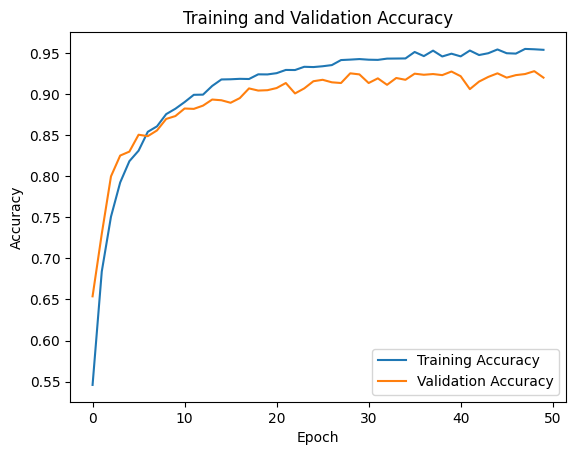

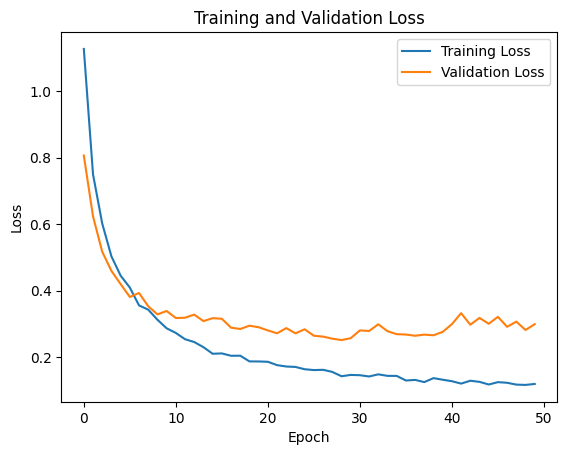

Gradient Boosted Trees Test Accuracy: 1.0
k-Nearest Neighbors Test Accuracy: 0.7888111888111888
Naive Bayes Test Accuracy: 0.2202797202797203


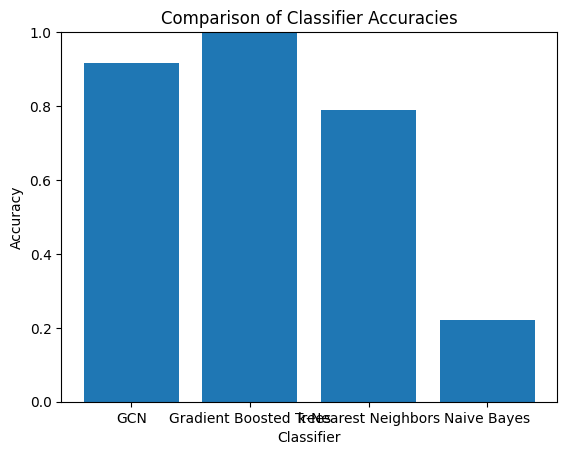

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Total runtime: 267.3239076137543 seconds


In [10]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import networkx.algorithms.community as nx_comm
import time
from sklearn.ensemble import GradientBoostingClassifier

# Function to train and evaluate different classifiers
def train_and_evaluate_classifier(classifier, train_features, train_labels, test_features, test_labels):
    classifier.fit(train_features, train_labels)
    accuracy = classifier.score(test_features, test_labels)
    return accuracy

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename, header=None, names=['source', 'target', 'weight'])

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return np.zeros((1024,), dtype=float)  # Return an array of zeros if molecule can't be parsed
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)  # Return an array of zeros in case of an error

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    # Categorize PLD into nonporous, small, medium, and large pore
    summary_data['PLD_category'] = pd.cut(summary_data['Pore Limiting Diameter'], bins=[-np.inf, 2.4, 4.5, 8, np.inf], labels=['nonporous', 'small pore', 'medium pore', 'large pore'])
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)
    labels = pd.get_dummies(summary_data['PLD_category']).values
    # Adjusted part: Use summary_data indices if they're complete and align with node labels
    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return features, labels
    else:
        # Handle cases where summary_data and node_labels don't align
        print("Warning: Mismatch between summary data and node labels.")
        return features, labels

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_graph(filename):
    """Loads the sparsified graph."""
    return nx.read_weighted_edgelist(filename)

def preprocess_features(features):
    """Preprocesses node features."""
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def build_gcn_model(input_shape, num_classes):
    """Builds a Graph Convolutional Network model."""
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

if __name__ == "__main__":
    start_time = time.time()

    edges_list_filename = 'sparsified_graph_edges_0.98.csv'
    summary_data_filename = '1M1L3D_summary.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    features, labels = load_summary_data(summary_data_filename, node_labels)
    graph = load_graph(edges_list_filename)

    # Preprocess features
    features = preprocess_features(features)

    # Split data into training and testing sets (you may want to use more advanced techniques for validation)
    train_idx = np.random.choice(len(features), size=int(0.8 * len(features)), replace=False)
    test_idx = np.setdiff1d(np.arange(len(features)), train_idx)

    train_features, train_labels = features[train_idx], labels[train_idx]
    test_features, test_labels = features[test_idx], labels[test_idx]

    # Build and compile GCN model
    model = build_gcn_model(train_features.shape[1], train_labels.shape[1])

    # Train the model
    history = model.fit(train_features, train_labels, epochs=50, batch_size=32, validation_split=0.2)

    # Calculate and store GCN model accuracy
    loss, accuracy = model.evaluate(test_features, test_labels)
    print("GCN Test Accuracy:", accuracy)

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Train and evaluate Gradient Boosted Trees
    gbt_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
    gbt_classifier.fit(train_features, np.argmax(train_labels, axis=1))
    gbt_accuracy = gbt_classifier.score(test_features, np.argmax(test_labels, axis=1))
    print("Gradient Boosted Trees Test Accuracy:", gbt_accuracy)

    # Train and evaluate k-Nearest Neighbors
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(train_features, np.argmax(train_labels, axis=1))
    knn_accuracy = knn_classifier.score(test_features, np.argmax(test_labels, axis=1))
    print("k-Nearest Neighbors Test Accuracy:", knn_accuracy)

    # Train and evaluate Naive Bayes
    nb_classifier = GaussianNB()
    nb_classifier.fit(train_features, np.argmax(train_labels, axis=1))
    nb_accuracy = nb_classifier.score(test_features, np.argmax(test_labels, axis=1))
    print("Naive Bayes Test Accuracy:", nb_accuracy)

    # Plot comparison of accuracies
    classifiers = ['GCN', 'Gradient Boosted Trees', 'k-Nearest Neighbors', 'Naive Bayes']
    accuracies = [accuracy, gbt_accuracy, knn_accuracy, nb_accuracy]

    plt.bar(classifiers, accuracies)
    plt.title('Comparison of Classifier Accuracies')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    # Save the model
    model.save("gcn_model.h5")

    print(f"Total runtime: {time.time() - start_time} seconds")


In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 12.6 MB/s eta 0:00:00


In [8]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/InverseLinkPredcition')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
